In [4]:
#import libraries
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.colors import NoNorm
import numpy as np
from numpy.random.mtrand import seed
import pandas as pd
from pandas.core.frame import DataFrame
import networkx as nx
import collections
from collections import Counter
from scipy.stats import poisson
import seaborn as sns
from pickle import NONE

# 1. Plot the network

In [5]:
#read csv file
df = pd.read_csv("large_twitch_edges.csv")
df2 = pd.read_csv("large_twitch_features.csv")

In [6]:
FI_df = df2.loc[df2['language'] == 'FI']
FI_df

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
748,1892,0,1928,2013-07-02,2018-10-12,748,0,FI,0
1192,2438,0,795,2016-08-06,2018-10-10,1192,0,FI,0
1229,5721,1,2082,2013-01-25,2018-10-08,1229,0,FI,0
2321,321,0,2023,2013-03-23,2018-10-06,2321,0,FI,0
2607,11664,0,2947,2010-08-21,2018-09-15,2607,0,FI,0
...,...,...,...,...,...,...,...,...,...
166371,3603,0,455,2017-07-11,2018-10-09,166371,0,FI,1
166916,1445,1,1124,2015-09-02,2018-09-30,166916,0,FI,0
167124,1847824,1,1242,2015-05-19,2018-10-12,167124,0,FI,0
167787,5311,0,1756,2013-12-16,2018-10-07,167787,0,FI,1


In [7]:
FI_list = FI_df['numeric_id'].tolist()

In [8]:
# A graph view of the network from edge list
G = nx.from_pandas_edgelist(df, source='numeric_id_1',target='numeric_id_2')

g = G.subgraph(FI_list)

In [9]:
# id_list contains all connected FI nodes
degree_dic = dict(g.degree())
id_list =[]
for id, degree in degree_dic.items():
    if degree != 0:
        id_list.append(id)
print(len(id_list))

609


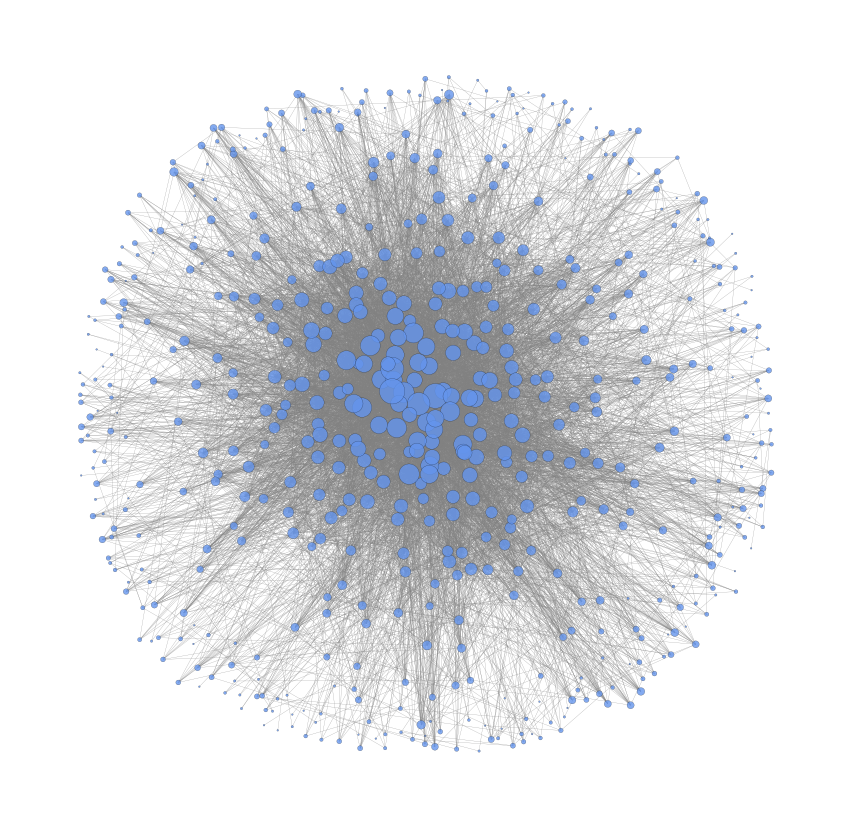

In [10]:
# A subgraph of the relationship between FI users
g = G.subgraph(id_list)

fig, ax = plt.subplots(figsize=(15,15))
pos = nx.spring_layout(g, k=1, seed = 1888)

degrees = dict(g.degree)

nx.draw_networkx_edges(g, pos=pos,width=0.2, edge_color='grey')

nx.draw_networkx_nodes(g, 
                       pos=pos, 
                       node_size=[v *3 for v in degrees.values()], 
                       linewidths=0.2, 
                       edgecolors='black', 
                       node_color= 'cornflowerblue',
                       alpha=0.8)

ax.axis("off")

plt.show()

In [11]:
#total number of nodes
n_nodes = len(g)
n_nodes

609

# 2. Analyse and plot the degree distribution of the network


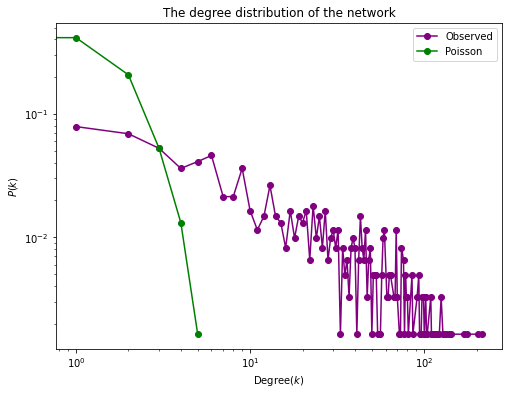

In [15]:
#get degree sequence
l = sorted([d for n, d in g.degree()], reverse=True)
#get the dictionary
k = Counter(l)

#generate poisson distribution for random network
np.random.seed(168)
x = np.random.poisson(1,size=n_nodes)
k1 = Counter(sorted(x))

#loglog plot of the degree distribution
fig,ax = plt.subplots(figsize=(8,6))
ax.loglog(k.keys(),[int(i)/n_nodes for i in k.values()] ,marker = 'o', color = 'purple', label='Observed')
ax.loglog(k1.keys(), [int(i)/n_nodes for i in k1.values()], marker = 'o',color='green', label='Poisson')
ax.set_xlabel('Degree($k$)')
ax.set_ylabel('$P(k)$')
ax.set_title('The degree distribution of the network')
ax.legend()
plt.show()

## 2.2 Fit powerlaw distribution

Calculating best minimal value for power law fit


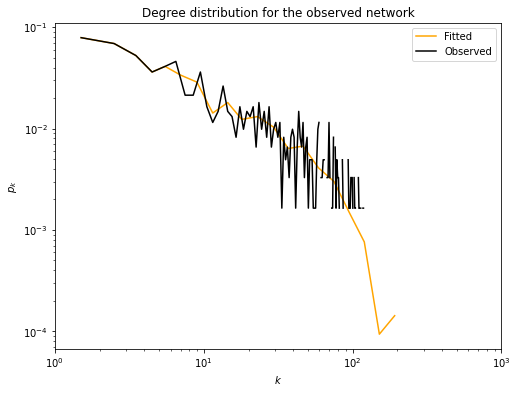

In [16]:
import powerlaw
# fit powerlaw   
x1 = [d for n, d in nx.degree(g)]
fit = powerlaw.Fit(x1) #degree distribution into powerlaw function
alpha = fit.power_law.alpha   
sigma = fit.power_law.sigma 
cmp = fit.distribution_compare('power_law', 'exponential')

# create figure
fig = plt.figure(figsize=(8, 6))
# add plot
ax2 = fig.add_subplot(1, 1, 1)

# plot data
powerlaw.plot_pdf(x1, color='orange', ax=ax2, label='Fitted') #plot the probability, plot the fitted line
powerlaw.plot_pdf(x1, linear_bins=True, color='black', ax=ax2, label='Observed')

# title
ax2.set_title("Degree distribution for the observed network")

#axes
ax2.set_xlim(np.min(x1),10**3)

# labels
ax2.set_ylabel(r"$p_{k}$")
ax2.set_xlabel(r"$k$")

ax2.legend()

# show plot
plt.show()

# 3. Descriptive statistics

In [17]:
#import libraries
from networkx.algorithms import degree_centrality
from networkx.algorithms import eigenvector_centrality
from networkx.algorithms import betweenness_centrality

In [18]:
# visualization options
sns.set_theme(style="ticks")

In [19]:
# degree
degree = degree_centrality(g)

In [20]:
# eigenvector_centrality
ec = eigenvector_centrality(g)

In [21]:
# betweeness centrality
bc = betweenness_centrality(g)

In [22]:
# visualize results
# --+ df
df_corr = pd.DataFrame({'degree': degree, 'eigenvector_centrality': ec,
                   'betweenness_centrality': bc})

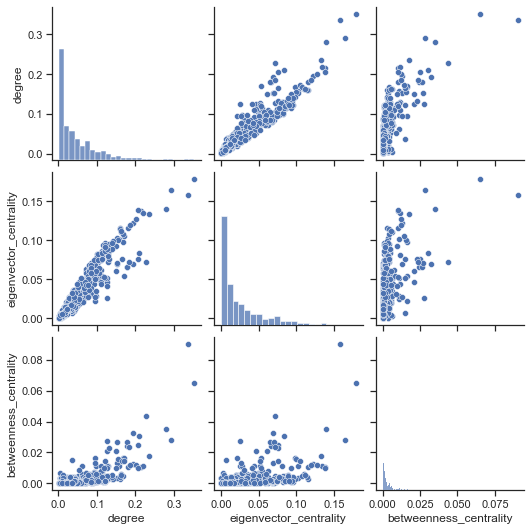

In [23]:
# --+ correlation matrix
df_corr.corr()

# --+ scatter plot matrix
sns.pairplot(df_corr)

## 3.2 Degree summary statistic

In [24]:
# Diameter 
print(' diameter: {}'.format(nx.diameter(g)))

 diameter: 6


In [25]:
# Summary of shortest path
for v in g.nodes():
  spl = dict(nx.single_source_shortest_path_length(g, v))
  p = list(spl.values())

print("""
==============================================
    Summary stats on shortest path 
==============================================
Mu    :       {:.3f}
Min   :       {:>5}
Max   :       {:>5}
Sigma :       {:.3f}
""".format(np.mean(p), np.min(p), np.max(p), np.std(p)))


    Summary stats on shortest path 
Mu    :       2.573
Min   :           0
Max   :           5
Sigma :       0.698



# 4. Use community detection to show a modular structure

In [ ]:
from networkx.algorithms.community import girvan_newman, modularity
import itertools
from pprint import pprint as pp
# %% use the modularity index to appreciate the quality of alternative
#    paritioning solutions
# fit
solutions = girvan_newman(g)
# alternative paritioning solutions to consider
k = 300
# register modularity scores
modularity_scores = dict()
# iterate over solutions
for community in itertools.islice(solutions, k, 350, 5):
    solution = list(sorted(c) for c in community)
    score = modularity(g, solution)
    modularity_scores[len(solution)] = score

# plot modularity data
fig = plt.figure(figsize=(8,6))
pos = list(modularity_scores.keys())
values = list(modularity_scores.values())
ax = fig.add_subplot(1, 1, 1)
ax.stem(pos, values)
ax.set_xticks(pos)
ax.set_xlabel(r'Number of communities detected')
ax.set_ylabel(r'Modularity score')
plt.show()

In [ ]:
# use the modularity index to appreciate the quality of alternative
# paritioning solutions
# fit
solutions = girvan_newman(g)
# alternative paritioning solutions to consider
k = 298
# register modularity scores
modularity_scores = dict()
# iterate over solutions
for community in itertools.islice(solutions, k, 320):
    solution = list(sorted(c) for c in community)
    score = modularity(g, solution)
    modularity_scores[len(solution)] = score

# plot modularity data
fig = plt.figure(figsize=(8,6))
pos = list(modularity_scores.keys())
values = list(modularity_scores.values())
ax = fig.add_subplot(1, 1, 1)
ax.stem(pos, values)
ax.set_xticks(pos)
ax.set_xlabel(r'Number of communities detected')
ax.set_ylabel(r'Modularity score')
plt.show()

## 4.1  Detecting core-periphery structure

In [43]:
#import library
import cpnet

In [ ]:
# Load the Borgatti-Everett algorithm
alg = cpnet.BE() 

# Give the network as an input
alg.detect(g) 

# Get the coreness of nodes
x1 = alg.get_coreness()  

# Get the group membership of nodes
c1 = alg.get_pair_id()  

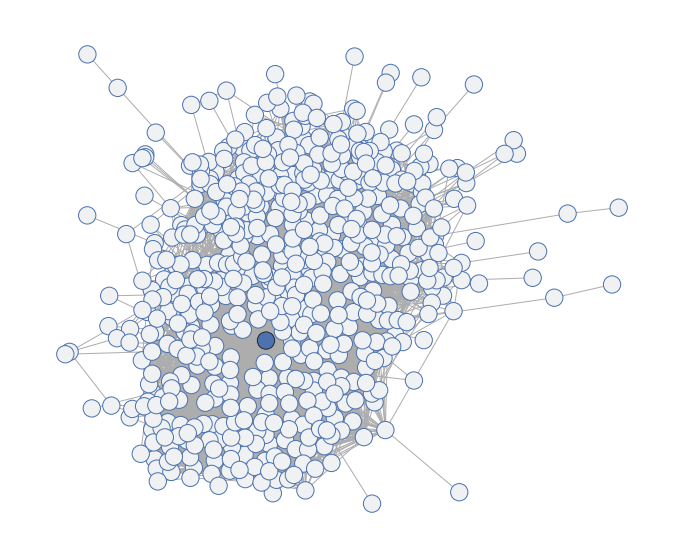

In [61]:
fig = plt.figure(figsize=(12, 10))
ax = plt.gca()
ax= cpnet.draw(g, c1, x1, ax, pos=pos)

## 4.2 Continuous core-periphery structure

In [ ]:
# Print the coreness value
alg = cpnet.MINRES()
alg.detect(g)
x2 = alg.get_coreness() 
c2 = alg.get_pair_id()

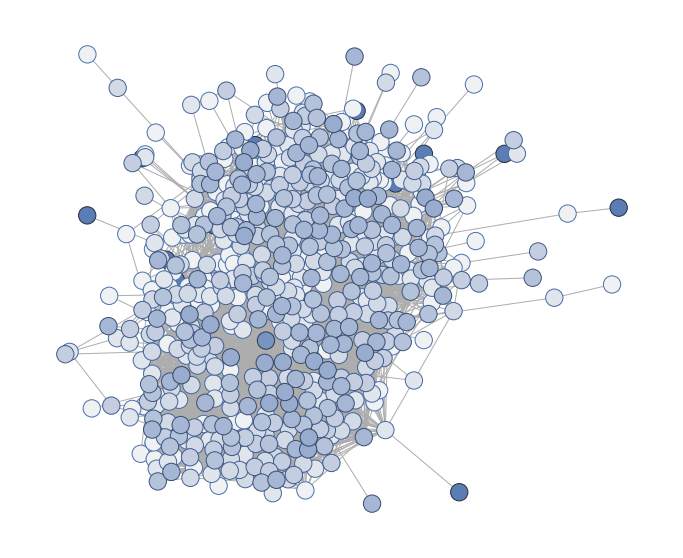

In [60]:
# visualise the continuous spectrum of coreness values
fig = plt.figure(figsize=(12, 10))
ax = plt.gca()
ax= cpnet.draw(g, c2, x2, ax, pos=pos)

## 4.3 Multiple core-periphery pairs

In [48]:
# Show the group membership of nodes
#KM algorithm
kmconfig = cpnet.KM_config()
kmconfig.detect(g)

c3 = kmconfig.get_pair_id()
x3 = kmconfig.get_coreness()

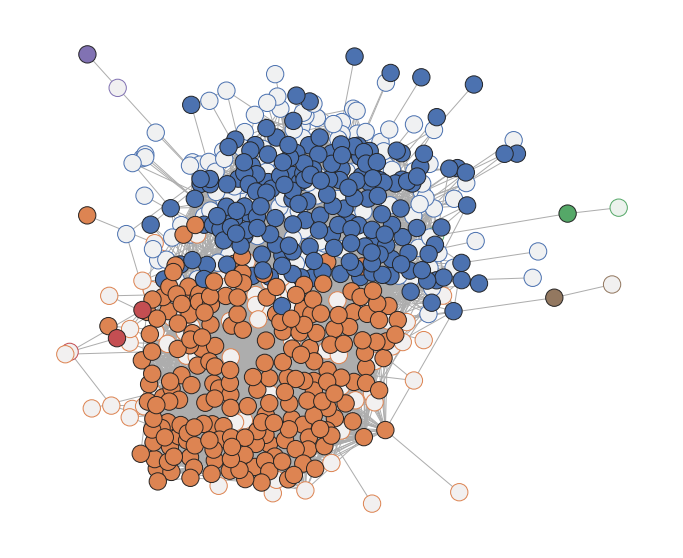

In [59]:
# Visualise the group membership
fig = plt.figure(figsize=(12, 10))
ax = plt.gca()
ax = cpnet.draw(g, c3, x3, ax, pos=pos) 